In [1]:
import numpy as np
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.linalg

In [2]:
# def GetSigmaPointsByHand(stateEstimate, stateCov, alpha, beta, kappa):
#     nStates = len(stateEstimate)
#     nSigmaPoints = 2*nStates + 1
    
#     lmd = (alpha**2)*(nStates + kappa) - nStates
#     sqrtMat = np.linalg.cholesky((lmd + nStates)*stateCov)
    
#     sigmaPoints = np.zeros((nStates, nSigmaPoints))
#     sigmaWeightsMean = np.zeros(nSigmaPoints)
#     sigmaWeightsCov = np.zeros(nSigmaPoints)
    
#     sigmaPoints[:, 0] = stateEstimate
#     sigmaWeightsMean[0] = lmd/(nStates + lmd)
#     sigmaWeightsCov[0] = (lmd/(nStates + lmd)) + (1 - (alpha**2) + beta)
    
#     for i in range(nStates):
#         sigmaPoints[:, i + 1] = stateEstimate + sqrtMat[:, i]
#         sigmaWeightsMean[i + 1] = 0.5/(nStates + lmd)
#         sigmaWeightsCov[i + 1] = 0.5/(nStates + lmd)
        
#         sigmaPoints[:, i + nStates + 1] = stateEstimate - sqrtMat[:, i]
#         sigmaWeightsMean[i + nStates + 1] = 0.5/(nStates + lmd)
#         sigmaWeightsCov[i + nStates + 1] = 0.5/(nStates + lmd)
    
#     return sigmaPoints, sigmaWeightsMean, sigmaWeightsCov

In [3]:
def GetSigmaPoints(stateEstimate, stateCov, alpha, beta, kappa):
    nStates = len(stateEstimate)
    nSigmaPoints = 2*nStates + 1
    sigmaPointsMat = np.zeros((nStates, nSigmaPoints))
    sigmaWeightsMean = np.zeros(nSigmaPoints)
    sigmaWeightsCov = np.zeros(nSigmaPoints)
    
    lambdaForSigmaPoints = (alpha**2)*(nStates + kappa) - nStates
    
    # Numpy cholesky of the for A = L*L.T, so columns of L to be used, (Unscented Filtering and Nonlinear Estimation, Julier and Uhlmann, 2004)
    sqrtStateCov = np.linalg.cholesky(stateCov*(nStates + lambdaForSigmaPoints))
#     sqrtStateCov = scipy.linalg.sqrtm(stateCov*(nStates + lambdaForSigmaPoints))
    
    sigmaPointsMat[:, 0] = stateEstimate
    sigmaWeightsMean[0] = lambdaForSigmaPoints/(nStates + lambdaForSigmaPoints)
    sigmaWeightsCov[0] = (lambdaForSigmaPoints/(nStates + lambdaForSigmaPoints)) + (1 - (alpha**2) + beta)
    
    for i in range(nStates):
        sigmaPointsMat[:, i + 1] = stateEstimate + sqrtStateCov[:, i]
        sigmaWeightsMean[i + 1] = 1/(2*(nStates + lambdaForSigmaPoints))
        sigmaWeightsCov[i + 1] = 1/(2*(nStates + lambdaForSigmaPoints))
        
        sigmaPointsMat[:, i + nStates + 1] = stateEstimate - sqrtStateCov[:, i]
        sigmaWeightsMean[i + nStates + 1] = 1/(2*(nStates + lambdaForSigmaPoints))
        sigmaWeightsCov[i + nStates + 1] = 1/(2*(nStates + lambdaForSigmaPoints))
        
    return sigmaPointsMat, sigmaWeightsMean, sigmaWeightsCov

In [4]:
def GetWeightedEstimate(pointsMat, weights):
    # pointsMat : nState x nPoints
    weightedEstimate = np.zeros(pointsMat.shape[0])
    for i in range(len(weights)):
        weightedEstimate = weightedEstimate + weights[i]*pointsMat[:, i]
    return weightedEstimate

In [5]:
def GetWeightedCov(pointsMat, weightedEstimate, weights):
    # pointsMat : len(weight) x nStates
    weightedCov = np.zeros((weightedEstimate.size, weightedEstimate.size))
    for i in range(len(weights)):
        tempVec = (pointsMat[:, i] - weightedEstimate).reshape([-1, 1])
        weightedCov = weightedCov + weights[i]*np.dot(tempVec, tempVec.T)
    return weightedCov

In [6]:
def GetWeightedCrossCov(pointsMat1, weightedEstimate1, pointsMat2, weightedEstimate2, weights):
    # pointsMat1,2 : len(weight) x nStates
    weightedCrossCov = np.zeros((weightedEstimate1.size, weightedEstimate2.size))
    for i in range(len(weights)):
        yTemp1 = (pointsMat1[:, i] - weightedEstimate1).reshape([-1, 1])
        yTemp2 = (pointsMat2[:, i] - weightedEstimate2).reshape([-1, 1])
        weightedCrossCov = weightedCrossCov + weights[i]*np.dot(yTemp1, yTemp2.T)
    return weightedCrossCov

In [7]:
def ForwardModel(sigmaPoint):
    tempState = np.zeros(2)
    tempState[0] = sigmaPoint[0] + sigmaPoint[2]
    tempState[1] = sigmaPoint[1] + sigmaPoint[3]
    return tempState

In [8]:
def ObservationModel(state, time, obsNoise):
    lmd = state[0]
    uL = 2.0
    uR = 1.0
    xR = state[1]
    
    beta = 2.0/lmd
    alpha = (uL - uR)/xR
    tBreak = 1/(beta*alpha)

    if(time < tBreak):
        skPos = (beta*uL*time + xR + beta*uR*time)/2
    else:
        sigma = (uL + uR)/lmd
        skPos = sigma*time + (xR/2)
    return skPos + obsNoise
    

In [9]:
nStates = 2 # lambda, xr
nStateNoise = 2 # lambdaNoise, xrNoise
nObs = 1 # ObservationNoise

nTotalStates = nStates + nStateNoise + nObs

In [10]:
nTSteps = 101
tSteps = np.linspace(0, 5, nTSteps)

obsNoiseCov = np.round(0.1**2, 4)

estimatedState = np.zeros((nStates, nTSteps))
estimatedCov = np.zeros((nStates, nStates, nTSteps))

In [11]:
estimatedState[:, 0] = [2.15, 0.85]

estimatedCov[:, :, 0] = np.diag([0.02083, 0.02083])

In [12]:
observationVec = scipy.io.loadmat("ex1_200_14-06-23_artificialDynamics_jackKnife.mat")["obsShockPos"][0]

In [13]:
alpha = 0.001
beta = 2
kappa = 0

In [14]:
estimatedObservationsVec = np.zeros(len(tSteps))

In [15]:
for it in tqdm(range(1, len(tSteps))):
    tTemp = tSteps[it]

    tempExtendedState = np.zeros(nTotalStates)
    tempExtendedState[0:nStates] = estimatedState[:, it - 1]

    tempExtendedCov = np.zeros((len(tempExtendedState), len(tempExtendedState)))
    tempExtendedCov[0:nStates, 0:nStates] = estimatedCov[:, :, it - 1]
    tempExtendedCov[nStates:nStates + nStateNoise, nStates:nStates + nStateNoise] = np.diag([0.0025, 0.0025])/it
    tempExtendedCov[-1, -1] = obsNoiseCov

    [sigmaPointsMat, sigmaWeightsMean,
         sigmaWeightsCov] = GetSigmaPoints(tempExtendedState, tempExtendedCov, alpha, beta, kappa)

    nSigmaPoints = len(sigmaWeightsMean)
    forwardedState = np.zeros((nStates, nSigmaPoints))
    forwardedObservations = np.zeros((nObs, nSigmaPoints))
    for iSigma in range(len(sigmaWeightsMean)):
            forwardedState[:, iSigma] = ForwardModel(sigmaPointsMat[:, iSigma])
            forwardedObservations[:, iSigma] = ObservationModel(forwardedState[:, iSigma], tTemp,
                                                                sigmaPointsMat[-1, iSigma])
    forwardedStateEstimate = GetWeightedEstimate(forwardedState, sigmaWeightsMean)
    forwardedStateCov = GetWeightedCov(forwardedState, forwardedStateEstimate, sigmaWeightsCov)

    forwardedObsEstimate = GetWeightedEstimate(forwardedObservations, sigmaWeightsMean)
    forwardedObsCov = GetWeightedCov(forwardedObservations, forwardedObsEstimate, sigmaWeightsCov)

    forwardedStateObsCrossCov = GetWeightedCrossCov(forwardedState, forwardedStateEstimate,
                                                    forwardedObservations, forwardedObsEstimate,
                                                    sigmaWeightsCov)

    kalmanGain = np.dot(forwardedStateObsCrossCov, np.linalg.inv(forwardedObsCov))
    estimatedState[:, it] = forwardedStateEstimate + np.dot(kalmanGain, 
                                                            (observationVec[it] - forwardedObsEstimate))
    estimatedCov[:, :, it] = forwardedStateCov - np.dot(kalmanGain,
                                                        np.dot(forwardedObsCov, kalmanGain.T))
    estimatedObservationsVec[it] = ObservationModel(estimatedState[:, it], tSteps[it], 0)

100%|██████████| 100/100 [00:00<00:00, 896.77it/s]


In [18]:
estimatedStateStd = np.zeros((nStates, len(tSteps)))
estimatedStateStd[0, :] = np.sqrt(estimatedCov[0, 0, :])
estimatedStateStd[1, :] = np.sqrt(estimatedCov[1, 1, :])

In [19]:
scipy.io.savemat("ex1UKFFromPy.mat", dict(estimatedState = estimatedState, estimatedCov = estimatedCov,
                                          tSteps = tSteps, estimatedStateStd = estimatedStateStd))

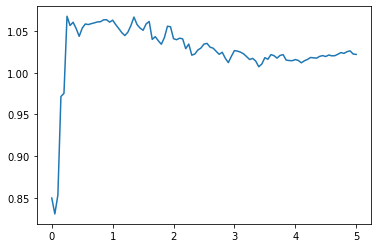

In [16]:
plt.plot(tSteps, estimatedState[1, :])

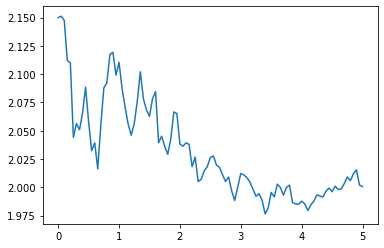

In [17]:
plt.plot(tSteps, estimatedState[0, :])


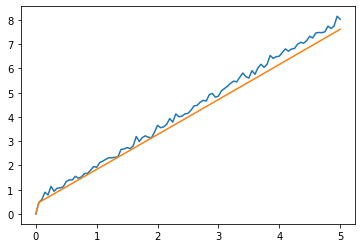

In [112]:
plt.plot(tSteps, observationVec)
plt.plot(tSteps, estimatedObservationsVec)

0.020833333333333332

In [50]:
# # 

# it = 1
# tTemp = tSteps[it]

# tempExtendedState = np.zeros(nTotalStates)
# tempExtendedState[0:nStates] = estimatedState[:, it - 1]

# tempExtendedCov = np.zeros((len(tempExtendedState), len(tempExtendedState)))
# tempExtendedCov[0:nStates, 0:nStates] = estimatedCov[:, :, it - 1]
# tempExtendedCov[nStates:nStates + nStateNoise, nStates:nStates + nStateNoise] = np.diag([0.0025, 0.0025])/(20*tTemp)
# tempExtendedCov[-1, -1] = obsNoiseCov
 
# [sigmaPointsMat, sigmaWeightsMean,
#      sigmaWeightsCov] = GetSigmaPoints(tempExtendedState, tempExtendedCov, alpha, beta, kappa)

# nSigmaPoints = len(sigmaWeightsMean)
# forwardedState = np.zeros((nStates, nSigmaPoints))
# forwardedObservations = np.zeros((nObs, nSigmaPoints))

# for iSigma in range(len(sigmaWeightsMean)):
#         forwardedState[:, iSigma] = ForwardModel(sigmaPointsMat[:, iSigma])
#         forwardedObservations[:, iSigma] = ObservationModel(forwardedState[:, iSigma], tTemp,
#                                                             sigmaPointsMat[-1, iSigma])
        
# forwardedStateEstimate = GetWeightedEstimate(forwardedState, sigmaWeightsMean)
# forwardedStateCov = GetWeightedCov(forwardedState, forwardedStateEstimate, sigmaWeightsCov)

# forwardedObsEstimate = GetWeightedEstimate(forwardedObservations, sigmaWeightsMean)
# forwardedObsCov = GetWeightedCov(forwardedObs, forwardedObsEstimate, sigmaWeightsCov)        

# forwardedStateObsCrossCov = GetWeightedCrossCov(forwardedState, forwardedStateEstimate,
#                                                 forwardedObservations, forwardedObsEstimate,
#                                                 sigmaWeightsCov)

# kalmanGain = np.dot(forwardedStateObsCrossCov, np.linalg.inv(forwardedObsCov))

# estimatedState[:, it] = forwardedStateEstimate + np.dot(kalmanGain, 
#                                                         (observationVec[it] - forwardedObsEstimate))

# estimatedCov[:, :, it] = forwardedStateCov - np.dot(kalmanGain,
#                                                     np.dot(forwardedObsCov, kalmanGain.T))

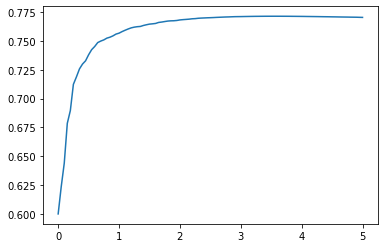

In [17]:
it

2